In [2]:
!pip install xgboost
!pip install colorama==0.4.4
!pip install bayesian-optimization==1.4.0
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from bayes_opt import BayesianOptimization
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score


# Configuration

In [28]:
# Config for the XG Boost Testing

# Where You Store the folder
Folder_Path = "C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-Parity-Research-Source-Code\\CUQTS_FXParity-main\\Result"

# TimeFrame List & Included Test Currencies
tf_list = ["1M", "3M"]
curr_list = ["USD", "JPY", "GBP", "CHF","AUD", "CAD", "NZD", "NOK", "SEK", "EUR"]
exp_return_threshold = 0 # When exp.return > threshold -> Classified as 1

# ML Metrics - Use as a *kwargs to initialize ML Variable in XGBoost Classifier
model_training_parameters = {
    'learning_rate': 0.2, 
    'gamma': 0.2, 
    'reg_alpha': 0.1,
    'objective': 'binary:logistic',
    'random_state': 4010,
}

# Additional Choices
default_threshold = 0
activate_search_threshold = False
predict_direction = "IRP" # PPP/IRP
drop_fe_list = ["start_date", "end_date", "realized_spot","initial_spot", "expected_spot", "expected_ret", "spot_error_pct"] # Initial Spots, Realized Spots, You may drop as many as you like (Sample Columns is as below)
time_lag = 2 # Will loop through shift 1, 2, ....(time_lag) as user inputs
time_lag_dict = {"1M":5, "3M":1}
predict_period_after = 1 # Use latest data to predict whether label after kth period will rise.

In [29]:
# Variable Adjustment

# Generated cross product of currency list
curr_pair_1 = curr_list
curr_pair_2 = curr_list
gen = ((x, y) for x in curr_pair_1 for y in curr_pair_2 if x != y)

# predict_direction - Later Implementation
# dir_from = predict_direction.split('-')[0]
# dir_to = predict_direction.split('-')[1]

In [30]:
#reading treasury rate

treasury_dict = {}
G_10 = curr_list
Maturity = tf_list

for currency in G_10:
    for maturity in Maturity:
        
        if currency == 'USD':
            ticker = 'USGG' + maturity + ' Index'
        else:
            ticker = 'GT'+ currency + maturity + ' Govt'
        try:
            treasury_data_df = pd.read_csv('C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-Parity-Research-Source-Code\\CUQTS_FXParity-main\\Treasury Rate\\' 
                                        + ticker + '.csv', header = 1, index_col = 0)
            treasury_dict[currency+'_'+maturity] = treasury_data_df
        except:
            treasury_dict[currency+'_'+maturity] = None


# Predefined function for later step

In [31]:
def feature_engine(result_df, time_lag):
    req_col = result_df.columns
    for col in req_col:
        #if col == "realized_ret":
        #    continue
        for i in range(1, time_lag + 1):
            result_df[f"{col}_shift{i}"] = result_df[col].shift(i)
    return result_df

def label_result(result_df, threshold = default_threshold):
    # Here you can add any label as you want...
    result_df["label"] = np.where(result_df["realized_ret"] > threshold, 1, 0)
    result_df["label"] = result_df["label"].shift(-predict_period_after)
    
    return result_df

def get_best_params(result_df):
    result_df = result_df.dropna()
    # set training parameters and label & split the testing set.
    X = result_df.drop(columns = ["label"])
    Y = result_df["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, Y)
    # Optimize the machine learning parameter
    # print(X_train, y_train)
    def xgb_cv(learning_rate, max_depth):
        params = {'learning_rate': learning_rate, 'max_depth': int(max_depth), 'objective': 'binary:logistic'}
        cv_result = xgb.XGBClassifier(**params).fit(X_train, y_train).predict_proba(X_test)[:,1]
        return f1_score(y_test, (cv_result > 0.5).astype(int))
    # Set up the Bayesian optimizer
    pbounds = {'learning_rate': (0.01, 1.0), 'max_depth': (1, 10)}
    optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=42)

    # Run the optimization loop
    optimizer.maximize(init_points=5, n_iter=10)
    best_params = optimizer.max['params']
    best_params["max_depth"] = int(best_params["max_depth"])
    return best_params

def get_best_classification(result_df):
    result_df = result_df.dropna()
    
    X = result_df
    Y = np.where(result_df["realized_ret"] > default_threshold, 1, 0)
    X_train, X_test, y_train, y_test = train_test_split(X, Y)

    def optimize_cf(threshold):
        param = {'threshold': threshold}
        return f1_score(y_train, (X_train["realized_ret"] > threshold).astype(int))
    pbounds = {'threshold': (-0.005, 0.005)}
    
    optimizer = BayesianOptimization(f=optimize_cf, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=5, n_iter=10)
    
    results = optimizer.res
    filtered_results = [result for result in results if result['target'] != 1.0]
    best_params = max(filtered_results, key=lambda x: x['target'])['params']["threshold"]
    # best_params = optimizer.max['params']
    return best_params

def trainXGModel(result_df, best_params):
    result_df = result_df.dropna()
    # set training parameters and label & split the testing set.
    X = result_df.drop(columns = ["label"])
    Y = result_df["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle = False)
    
    # Fit the model
    model = xgb.XGBClassifier(**model_training_parameters)
    # model = xgb.XGBClassifier(**best_params)
    model.fit(X_train, y_train)
    
    # Get the feature importance object
    tmp_df = pd.DataFrame(model.feature_importances_.reshape(1, -1), columns=X.columns)
    obj = tmp_df.to_dict(orient='records')[0]
    
    # Predict the model 
    y_pred = pd.DataFrame(model.predict(X_test), index=y_test.index)
    accuracy = accuracy_score(y_test, y_pred)
    
    return (accuracy, obj, y_pred)

# Main Logic 

In [33]:
gen = ((x, y) for x in curr_pair_1 for y in curr_pair_2 if x != y)

accuracy_df = pd.DataFrame()
accuracy_df.index = tf_list
feature_importance_df = pd.DataFrame()
feature_importance_df.index = tf_list

for c1, c2 in gen:
    across_pair_df_1M = pd.DataFrame()
    across_pair_df_3M = pd.DataFrame()
    
    acc_ls = []
    fe_importance_ls = []
    
    for tf in tf_list:
        time_lag = time_lag_dict[tf]
        try:
            # 1. Access file and create df
            
            result_df = pd.read_csv(f'{Folder_Path}\\{predict_direction}\\{c1 + c2}\\Data Details\\{tf}.csv', index_col=0)
            result_df.index = result_df["end_date"]
            
            if predict_direction == "PPP":
                result_df.index = pd.to_datetime(result_df.index)

                tmp = pd.read_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-Parity-Research-Source-Code\\CUQTS_FXParity-main\\Data\\CPI\\{c1}.csv', index_col=0, header = 1)
                tmp.index = pd.to_datetime(tmp.index)
                result_df['base_econ'] = tmp["Last_Price"].resample(tf).last()

                tmp = pd.read_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-Parity-Research-Source-Code\\CUQTS_FXParity-main\\Data\\CPI\\{c2}.csv', index_col=0, header = 1)
                tmp.index = pd.to_datetime(tmp.index)
                result_df['pricing_econ'] = tmp["Last_Price"].resample(tf).last()
                
            else:
                tmp = treasury_dict[c1+'_'+tf]
                result_df['base_econ'] = tmp["Last_Price"].loc[result_df['start_date']]

                tmp = treasury_dict[c2+'_'+tf]
                result_df['pricing_econ'] = tmp["Last_Price"].loc[result_df['start_date']]
                

            # tmp = pd.read_csv(f'C:/Users/johnn/Downloads/Currency_Data/{c1 + c2}.csv', index_col=0)
            # tmp.index = pd.to_datetime(tmp.index)
            # result_df[c1 + c2] = tmp["Last_Price"].resample(tf).last()
            
            result_df.index = result_df["end_date"]
            # 2.1 Drop unnecessary columns
            result_df = result_df.drop(columns=drop_fe_list)
            # 2.2 Feature Engineering
            result_df = feature_engine(result_df, time_lag)
            # 2.3 Labelling result and predict kth period after
            if activate_search_threshold:
                threshold = get_best_classification(result_df)
            result_df = label_result(result_df, default_threshold)
            #result_df = result_df.drop(columns=["realized_ret"])
            
            # print(result_df, threshold)
            # 3. Train & Test Model
            print(c1, c2)
            best_params = get_best_params(result_df) # Train the best ML Metrics using Bayesian Search
            accuracy, fe_obj, y_pred = trainXGModel(result_df, best_params)
            print(y_pred.index)
            y_pred.to_csv(f"C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_04_03\\XG_Boost_Prediction\\{predict_direction}_{c1+c2}_{tf}_shift{predict_period_after}.csv")
            # 4. Append the objects
            acc_ls.append(accuracy)
            fe_importance_ls.append(fe_obj)

            # 5. Concat all the same tf obj
            concatenated_df = pd.concat([result_df, eval(f"across_pair_df_{tf}")])
            globals()[f"across_pair_df_{tf}"] = concatenated_df
        except:
            acc_ls.append(np.NaN)
            fe_importance_ls.append(np.NaN)
    accuracy_df[c1 + c2] = acc_ls
    feature_importance_df[c1 + c2] = fe_importance_ls

USD JPY
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.6154    | 0.3808    | 9.556     |
| 2         | 0.7143    | 0.7347    | 6.388     |
| 3         | 0.6154    | 0.1645    | 2.404     |
| 4         | 0.6667    | 0.0675    | 8.796     |
| 5         | 0.6154    | 0.6051    | 7.373     |
| 6         | 0.7143    | 0.7405    | 6.377     |
| 7         | 0.6154    | 0.2212    | 6.099     |
| 8         | 0.7143    | 0.9956    | 6.582     |
| 9         | 0.6154    | 0.9987    | 5.712     |
| 10        | 0.6154    | 1.0       | 1.0       |
| 11        | 0.6154    | 1.0       | 3.899     |
| 12        | 0.6154    | 0.7741    | 8.538     |
| 13        | 0.7143    | 0.9975    | 6.325     |
| 14        | 0.6154    | 0.01      | 4.467     |
| 15        | 0.5714    | 0.01016   | 1.096     |
Index(['2022-04-14', '2022-05-12', '2022-06-09', '2022-07-07', '2022-08-04',
       '2022-09-01', '2022-09-29', '2022-10-27', '2022-11-24'],
 

| 5         | 0.5185    | 0.6051    | 7.373     |
| 6         | 0.4615    | 0.6762    | 5.777     |
| 7         | 0.5217    | 0.06064   | 2.281     |
| 8         | 0.48      | 0.1103    | 5.695     |
| 9         | 0.64      | 0.1488    | 2.415     |
| 10        | 0.5833    | 0.2434    | 2.537     |
| 11        | 0.4762    | 0.3759    | 2.332     |
| 12        | 0.5833    | 0.1573    | 2.417     |
| 13        | 0.64      | 0.1643    | 2.391     |
| 14        | 0.5833    | 0.1373    | 2.383     |
| 15        | 0.4348    | 0.6933    | 2.102     |
Index(['2018-07-11', '2018-10-03', '2018-12-26', '2019-03-20', '2019-06-12',
       '2019-09-04', '2019-11-27', '2020-02-19', '2020-05-13', '2020-08-05',
       '2020-10-28', '2021-01-20', '2021-04-14', '2021-07-07', '2021-09-29',
       '2021-12-22', '2022-03-16', '2022-06-08', '2022-08-31'],
      dtype='object', name='end_date')
USD NZD
USD NOK
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------


| 7         | 0.0       | 0.9835    | 10.0      |
| 8         | 0.3333    | 0.9795    | 6.954     |
| 9         | 0.0       | 0.05958   | 6.933     |
| 10        | 0.0       | 1.0       | 7.557     |
| 11        | 0.0       | 1.0       | 6.599     |
| 12        | 0.0       | 0.7943    | 7.131     |
| 13        | 0.3333    | 0.496     | 7.454     |
| 14        | 0.5714    | 0.4472    | 7.293     |
| 15        | 0.3333    | 0.3225    | 7.294     |
Index(['2021-06-02', '2021-08-25', '2021-11-17', '2022-02-09', '2022-05-06',
       '2022-07-29'],
      dtype='object', name='end_date')
JPY SEK
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.2857    | 0.3808    | 9.556     |
| 2         | 0.2857    | 0.7347    | 6.388     |
| 3         | 0.2857    | 0.1645    | 2.404     |
| 4         | 0.2857    | 0.0675    | 8.796     |
| 5         | 0.0       | 0.6051    | 7.373     |
| 6         | 0.0       | 0.4768    | 9.582     |
| 7 

C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\skl

| 1         | 0.0       | 0.3808    | 9.556     |
| 2         | 0.0       | 0.7347    | 6.388     |
| 3         | 0.0       | 0.1645    | 2.404     |
| 4         | 0.0       | 0.0675    | 8.796     |
| 5         | 0.0       | 0.6051    | 7.373     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 6         | 0.0       | 0.9919    | 1.008     |
| 7         | 0.0       | 0.9984    | 1.004     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 8         | 0.0       | 0.08388   | 10.0      |
| 9         | 0.0       | 0.01119   | 1.016     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 10        | 0.0       | 0.9959    | 9.999     |
| 11        | 0.0       | 0.9652    | 1.003     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 12        | 0.0       | 0.9166    | 9.998     |
| 13        | 0.0       | 0.05485   | 1.015     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 14        | 0.0       | 0.0568    | 9.995     |
| 15        | 0.0       | 0.04508   | 1.002     |
Index(['2022-05-17'], dtype='object', name='end_date')
GBP CAD
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.6667    | 0.3808    | 9.556     |
| 2         | 0.6667    | 0.7347    | 6.388     |
| 3         | 0.6667    | 0.1645    | 2.404     |
| 4         | 0.6667    | 0.0675    | 8.796     |
| 5         | 0.6667    | 0.6051    | 7.373     |
| 6         | 0.6       | 0.9919    | 1.008     |
| 7         | 0.9091    | 0.01      | 3.981     |
| 8         | 0.6667    | 0.733     | 4.28      |
| 9         | 0.8       | 0.02517   | 3.985     |
| 10        | 0.6667    | 0.6709    | 6.78      |
| 11        | 0.8       | 0.0226    | 3.978     |
| 12        | 0.6667    | 0.4474    | 8.419     |
| 13        | 0.6667    | 0.07069   | 4.01      |
| 14        | 0.9091    | 0.01317   | 3.957     |
| 15        | 0.6667    | 0.6933    |

C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\skl

| 4         | 0.0       | 0.0675    | 8.796     |
| 5         | 0.0       | 0.6051    | 7.373     |
| 6         | 0.0       | 0.9919    | 1.008     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 7         | 0.0       | 0.9984    | 1.004     |
| 8         | 0.0       | 0.08388   | 10.0      |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 9         | 0.0       | 0.01119   | 1.016     |
| 10        | 0.0       | 0.9959    | 9.999     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 11        | 0.0       | 0.9652    | 1.003     |
| 12        | 0.0       | 0.9166    | 9.998     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 13        | 0.0       | 0.05485   | 1.015     |
| 14        | 0.0       | 0.0568    | 9.995     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 15        | 0.0       | 0.04508   | 1.002     |
Index(['2022-08-09'], dtype='object', name='end_date')
AUD CAD
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.0       | 0.3808    | 9.556     |
| 2         | 0.0       | 0.7347    | 6.388     |
| 3         | 0.0       | 0.1645    | 2.404     |
| 4         | 0.0       | 0.0675    | 8.796     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\skl

| 5         | 0.0       | 0.6051    | 7.373     |
| 6         | 0.0       | 0.9919    | 1.008     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 7         | 0.0       | 0.9984    | 1.004     |
| 8         | 0.0       | 0.08388   | 10.0      |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 9         | 0.0       | 0.01119   | 1.016     |
| 10        | 0.0       | 0.9959    | 9.999     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 11        | 0.0       | 0.9652    | 1.003     |
| 12        | 0.0       | 0.9166    | 9.998     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 13        | 0.0       | 0.05485   | 1.015     |
| 14        | 0.0       | 0.0568    | 9.995     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 15        | 0.0       | 0.04508   | 1.002     |
Index(['2022-08-09'], dtype='object', name='end_date')
AUD NOK
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.0       | 0.3808    | 9.556     |
| 2         | 0.0       | 0.7347    | 6.388     |
| 3         | 0.0       | 0.1645    | 2.404     |
| 4         | 0.0       | 0.0675    | 8.796     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\skl

| 5         | 0.0       | 0.6051    | 7.373     |
| 6         | 0.0       | 0.9919    | 1.008     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 7         | 0.0       | 0.9984    | 1.004     |
| 8         | 0.0       | 0.08388   | 10.0      |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 9         | 0.0       | 0.01119   | 1.016     |
| 10        | 0.0       | 0.9959    | 9.999     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 11        | 0.0       | 0.9652    | 1.003     |
| 12        | 0.0       | 0.9166    | 9.998     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 13        | 0.0       | 0.05485   | 1.015     |
| 14        | 0.0       | 0.0568    | 9.995     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 15        | 0.0       | 0.04508   | 1.002     |
Index(['2022-08-10'], dtype='object', name='end_date')
AUD SEK
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
CAD JPY
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.2667    | 0.3808    | 9.556     |
| 2         | 0.4       | 0.7347    | 6.388     |
| 3         | 0.2667    | 0.1645    | 2.404     |
| 4         | 0.25      | 0.0675    | 8.796     |
| 5         | 0.2667    | 0.6051    | 7.373     |
| 6         | 0.3333    | 0.7622    | 6.179     |
| 7         | 0.25      | 0.5796    | 6.452     |
| 8         | 0.25      | 0.1103    | 5.695     |
| 9         | 0.3529    | 0.01559   | 5.174     |
| 10        | 0.2353    | 0.6709    | 6.78      |
| 11        | 0.2353    | 0.04215   | 2.937     |
| 12        | 0.2222    | 0.4474    | 8.419     |
| 13        | 0.3333    | 0.02843   | 4.945     |
| 14        | 0.2667    | 0.4

| 4         | 0.5455    | 0.0675    | 8.796     |
| 5         | 0.5455    | 0.6051    | 7.373     |
| 6         | 0.5714    | 1.0       | 1.0       |
| 7         | 0.5455    | 0.01      | 3.413     |
| 8         | 0.6957    | 0.1939    | 2.237     |
| 9         | 0.5714    | 0.8727    | 2.43      |
| 10        | 0.7407    | 0.01      | 1.774     |
| 11        | 0.7407    | 0.01      | 1.159     |
| 12        | 0.7407    | 0.01785   | 1.468     |
| 13        | 0.7407    | 0.01      | 1.0       |
| 14        | 0.6923    | 0.01      | 2.113     |
| 15        | 0.5455    | 1.0       | 4.806     |
Index(['2019-05-08', '2019-07-31', '2019-10-23', '2020-01-15', '2020-04-08',
       '2020-07-01', '2020-09-23', '2020-12-16', '2021-03-10', '2021-06-02',
       '2021-08-25', '2021-11-17', '2022-02-09', '2022-05-06', '2022-07-29'],
      dtype='object', name='end_date')
EUR AUD
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.0    

C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\skl

| 3         | 0.0       | 0.1645    | 2.404     |
| 4         | 0.0       | 0.0675    | 8.796     |
| 5         | 0.0       | 0.6051    | 7.373     |
| 6         | 0.0       | 0.9919    | 1.008     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 7         | 0.0       | 0.9984    | 1.004     |
| 8         | 0.0       | 0.08388   | 10.0      |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 9         | 0.0       | 0.01119   | 1.016     |
| 10        | 0.0       | 0.9959    | 9.999     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 11        | 0.0       | 0.9652    | 1.003     |
| 12        | 0.0       | 0.9166    | 9.998     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 13        | 0.0       | 0.05485   | 1.015     |
| 14        | 0.0       | 0.0568    | 9.995     |


C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\anson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| 15        | 0.0       | 0.04508   | 1.002     |
Index(['2022-08-09'], dtype='object', name='end_date')
EUR CAD
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.4706    | 0.3808    | 9.556     |
| 2         | 0.4211    | 0.7347    | 6.388     |
| 3         | 0.3529    | 0.1645    | 2.404     |
| 4         | 0.5       | 0.0675    | 8.796     |
| 5         | 0.4444    | 0.6051    | 7.373     |
| 6         | 0.4444    | 1.0       | 8.689     |
| 7         | 0.6       | 0.01      | 8.144     |
| 8         | 0.4706    | 0.3415    | 8.161     |
| 9         | 0.5714    | 0.01536   | 8.162     |
| 10        | 0.5714    | 0.02528   | 8.087     |
| 11        | 0.5714    | 0.02391   | 8.074     |
| 12        | 0.5       | 0.06598   | 8.785     |
| 13        | 0.5714    | 0.0272    | 7.95      |
| 14        | 0.4444    | 0.147     | 7.956     |
| 15        | 0.5714    | 0.0155    | 7.814     |
Index(['2019-01-23', '2019-04-17', '2

# General Insight

<AxesSubplot:>

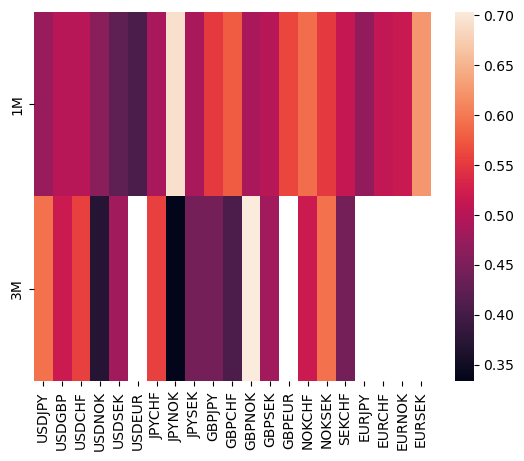

In [211]:
sns.heatmap(accuracy_df.dropna(axis=1, how='all'))

In [212]:
accuracy_df.dropna(axis=1, how='all')

,USDJPY,USDGBP,USDCHF,USDNOK,USDSEK,USDEUR,JPYCHF,JPYNOK,JPYSEK,GBPJPY,...,GBPNOK,GBPSEK,GBPEUR,NOKCHF,NOKSEK,SEKCHF,EURJPY,EURCHF,EURNOK,EURSEK
1M,0.474359,0.500000,0.500000,0.461538,0.423077,0.40625,0.487179,0.692308,0.487179,0.551282,...,0.487179,0.500000,0.561404,0.589744,0.551282,0.512821,0.46875,0.508772,0.515625,0.625
3M,0.592593,0.518519,0.555556,0.370370,0.481481,NaN,0.555556,0.333333,0.444444,0.444444,...,0.703704,0.481481,NaN,0.518519,0.592593,0.444444,NaN,NaN,NaN,NaN


In [213]:
accuracy_df.T["1M"].nlargest(10)

JPYNOK    0.692308
EURSEK    0.625000
NOKCHF    0.589744
GBPCHF    0.576923
GBPEUR    0.561404
GBPJPY    0.551282
NOKSEK    0.551282
EURNOK    0.515625
SEKCHF    0.512821
EURCHF    0.508772
Name: 1M, dtype: float64

# Feature Importance

In [214]:
feature_importance_df = feature_importance_df.dropna(axis=1, how='all')

In [215]:
feature_importance_df

,USDJPY,USDGBP,USDCHF,USDNOK,USDSEK,USDEUR,JPYCHF,JPYNOK,JPYSEK,GBPJPY,...,GBPNOK,GBPSEK,GBPEUR,NOKCHF,NOKSEK,SEKCHF,EURJPY,EURCHF,EURNOK,EURSEK
1M,"{'spread': 0.04917031154036522, 'realized_ret'...","{'spread': 0.03383781388401985, 'realized_ret'...","{'spread': 0.03372298926115036, 'realized_ret'...","{'spread': 0.022451303899288177, 'realized_ret...","{'spread': 0.06004229560494423, 'realized_ret'...","{'spread': 0.041547395288944244, 'realized_ret...","{'spread': 0.0441669337451458, 'realized_ret':...","{'spread': 0.04346388578414917, 'realized_ret'...","{'spread': 0.03801807761192322, 'realized_ret'...","{'spread': 0.053859893232584, 'realized_ret': ...",...,"{'spread': 0.05462643504142761, 'realized_ret'...","{'spread': 0.03855537623167038, 'realized_ret'...","{'spread': 0.03647390380501747, 'realized_ret'...","{'spread': 0.03817247226834297, 'realized_ret'...","{'spread': 0.028443943709135056, 'realized_ret...","{'spread': 0.05391939729452133, 'realized_ret'...","{'spread': 0.03615128621459007, 'realized_ret'...","{'spread': 0.05599804222583771, 'realized_ret'...","{'spread': 0.04732099547982216, 'realized_ret'...","{'spread': 0.035109009593725204, 'realized_ret..."
3M,"{'spread': 0.13910004496574402, 'realized_ret'...","{'spread': 0.12376248091459274, 'realized_ret'...","{'spread': 0.10456457734107971, 'realized_ret'...","{'spread': 0.129750058054924, 'realized_ret': ...","{'spread': 0.1706135869026184, 'realized_ret':...",NaN,"{'spread': 0.1604088693857193, 'realized_ret':...","{'spread': 0.1384223997592926, 'realized_ret':...","{'spread': 0.13403111696243286, 'realized_ret'...","{'spread': 0.10190268605947495, 'realized_ret'...",...,"{'spread': 0.13958115875720978, 'realized_ret'...","{'spread': 0.13314320147037506, 'realized_ret'...",NaN,"{'spread': 0.10304838418960571, 'realized_ret'...","{'spread': 0.16864508390426636, 'realized_ret'...","{'spread': 0.13604943454265594, 'realized_ret'...",NaN,NaN,NaN,NaN


In [216]:
tmp_obj = {}
restruc_df = pd.DataFrame()

# Flatten each values in df -> Append the Array 
for value in feature_importance_df.values.flatten():
    if type(value) != type(tmp_obj):
        continue
    for k, v in value.items():
        if k not in tmp_obj:
            tmp_obj[k] = []
        tmp_obj[k].append(v)
        
# Find the mean of each Feature    

# for k,v in tmp_obj.items():
#     restruc_df[k] = [np.mean(v)]

In [217]:
col_name = feature_importance_df.columns
index_arr = []
for index, row in feature_importance_df.iterrows():
    for col in col_name:
        if not pd.isnull(row[col]):
            index_arr.append(f"{col}_{index}")
length = len(index_arr)        

In [218]:
filtered_dict = {
    key: value for key, value in tmp_obj.items() if len(value) == length
}

In [219]:
feature_df = pd.DataFrame(data= filtered_dict, index= index_arr)
feature_df.to_csv('C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_04_03\\XG_Boost_Feature_Importance\\Feature Importance_PPP.csv')

In [220]:
feature_df

,spread,realized_ret,base_econ,pricing_econ,spread_shift1,realized_ret_shift1,base_econ_shift1,pricing_econ_shift1
USDJPY_1M,0.049170,0.044163,0.044173,0.029470,0.036271,0.046648,0.034280,0.033489
USDGBP_1M,0.033838,0.031840,0.024140,0.048905,0.043247,0.039930,0.047942,0.045039
USDCHF_1M,0.033723,0.047400,0.015672,0.042561,0.044978,0.040524,0.049117,0.041159
USDNOK_1M,0.022451,0.041236,0.044292,0.051505,0.038681,0.039874,0.054768,0.044575
USDSEK_1M,0.060042,0.032550,0.040209,0.038961,0.042617,0.038445,0.053867,0.049399
USDEUR_1M,0.041547,0.039304,0.030258,0.046998,0.029157,0.045949,0.046122,0.034282
JPYCHF_1M,0.044167,0.033605,0.032030,0.051516,0.040315,0.040415,0.036299,0.035180
JPYNOK_1M,0.043464,0.051949,0.029595,0.048903,0.038493,0.043225,0.037936,0.036516
JPYSEK_1M,0.038018,0.039478,0.033742,0.029773,0.038433,0.034193,0.037634,0.032215
GBPJPY_1M,0.053860,0.039013,0.045931,0.049787,0.037549,0.038043,0.059189,0.026265


In [221]:
feature_df.loc["USDJPY_1M"].nlargest(5)

spread                 0.049170
realized_ret_shift1    0.046648
base_econ              0.044173
realized_ret           0.044163
spread_shift1          0.036271
Name: USDJPY_1M, dtype: float64

In [222]:
feature_df.T["spread"].nlargest(5)

KeyError: 'spread'

In [223]:
for k,v in tmp_obj.items():
    print(k, len(v))

spread 36
realized_ret 36
base_econ 36
pricing_econ 36
spread_shift1 36
spread_shift2 21
spread_shift3 21
spread_shift4 21
spread_shift5 21
realized_ret_shift1 36
realized_ret_shift2 21
realized_ret_shift3 21
realized_ret_shift4 21
realized_ret_shift5 21
base_econ_shift1 36
base_econ_shift2 21
base_econ_shift3 21
base_econ_shift4 21
base_econ_shift5 21
pricing_econ_shift1 36
pricing_econ_shift2 21
pricing_econ_shift3 21
pricing_econ_shift4 21
pricing_econ_shift5 21


# Feature Importance (Updated)

In [224]:
feature_list = [k for k, v in tmp_obj.items()]
iterables = [tf_list, feature_list]

multi_index = pd.MultiIndex.from_product(iterables, names=["timeframe", "feature"])

In [225]:
feature_new_df = pd.DataFrame()
feature_new_df.index = multi_index

In [226]:
feature_new_df

Empty DataFrame
Columns: []
Index: [(1M, spread), (1M, realized_ret), (1M, base_econ), (1M, pricing_econ), (1M, spread_shift1), (1M, spread_shift2), (1M, spread_shift3), (1M, spread_shift4), (1M, spread_shift5), (1M, realized_ret_shift1), (1M, realized_ret_shift2), (1M, realized_ret_shift3), (1M, realized_ret_shift4), (1M, realized_ret_shift5), (1M, base_econ_shift1), (1M, base_econ_shift2), (1M, base_econ_shift3), (1M, base_econ_shift4), (1M, base_econ_shift5), (1M, pricing_econ_shift1), (1M, pricing_econ_shift2), (1M, pricing_econ_shift3), (1M, pricing_econ_shift4), (1M, pricing_econ_shift5), (3M, spread), (3M, realized_ret), (3M, base_econ), (3M, pricing_econ), (3M, spread_shift1), (3M, spread_shift2), (3M, spread_shift3), (3M, spread_shift4), (3M, spread_shift5), (3M, realized_ret_shift1), (3M, realized_ret_shift2), (3M, realized_ret_shift3), (3M, realized_ret_shift4), (3M, realized_ret_shift5), (3M, base_econ_shift1), (3M, base_econ_shift2), (3M, base_econ_shift3), (3M, base_econ_shift4), (3M, base_econ_shift5), (3M, pricing_econ_shift1), (3M, pricing_econ_shift2), (3M, pricing_econ_shift3), (3M, pricing_econ_shift4), (3M, pricing_econ_shift5)]

In [227]:
for index, row in feature_importance_df.iterrows():
    for col in feature_importance_df.columns:
        # row[col] is the objection
        if not pd.isnull(row[col]):
            for key, value in row[col].items():
                feature_new_df.loc[(index, key), col] = value
feature_new_df.dropna(how='all')

USDJPY    USDGBP    USDCHF    USDNOK  \
timeframe feature                                                       
1M        spread               0.049170  0.033838  0.033723  0.022451   
          realized_ret         0.044163  0.031840  0.047400  0.041236   
          base_econ            0.044173  0.024140  0.015672  0.044292   
          pricing_econ         0.029470  0.048905  0.042561  0.051505   
          spread_shift1        0.036271  0.043247  0.044978  0.038681   
          spread_shift2        0.036966  0.052816  0.040198  0.045663   
          spread_shift3        0.041317  0.040204  0.038121  0.039605   
          spread_shift4        0.051049  0.040273  0.037269  0.048412   
          spread_shift5        0.040092  0.061040  0.041728  0.041015   
          realized_ret_shift1  0.046648  0.039930  0.040524  0.039874   
          realized_ret_shift2  0.039436  0.043680  0.045504  0.048332   
          realized_ret_shift3  0.040455  0.032983  0.034074  0.043777   
          realized_ret_shift4  0.041530  0.030659  0.037026  0.042517   
          realized_ret_shift5  0.048582  0.039517  0.051661  0.045723   
          base_econ_shift1     0.034280  0.047942  0.049117  0.054768   
          base_econ_shift2     0.040731  0.062478  0.052160  0.034239   
          base_econ_shift3     0.052482  0.033575  0.051574  0.034125   
          base_econ_shift4     0.038705  0.037451  0.057310  0.049179   
          base_econ_shift5     0.039880  0.034254  0.041956  0.048359   
          pricing_econ_shift1  0.033489  0.045039  0.041159  0.044575   
          pricing_econ_shift2  0.044002  0.062482  0.038004  0.035436   
          pricing_econ_shift3  0.041601  0.029654  0.056215  0.027138   
          pricing_econ_shift4  0.027872  0.040189  0.034296  0.032983   
          pricing_econ_shift5  0.057635  0.043864  0.027771  0.046113   
3M        spread               0.139100  0.123762  0.104565  0.129750   
          realized_ret         0.114124  0.072689  0.134137  0.149414   
          base_econ            0.146976  0.115919  0.092188  0.074755   
          pricing_econ         0.128082  0.102517  0.088812  0.067454   
          spread_shift1        0.103824  0.143185  0.121734  0.155908   
          realized_ret_shift1  0.120771  0.159222  0.111025  0.108386   
          base_econ_shift1     0.116113  0.101307  0.180537  0.094663   
          pricing_econ_shift1  0.131010  0.181398  0.167001  0.219671   

                                 USDSEK    USDEUR    JPYCHF    JPYNOK  \
timeframe feature                                                       
1M        spread               0.060042  0.041547  0.044167  0.043464   
          realized_ret         0.032550  0.039304  0.033605  0.051949   
          base_econ            0.040209  0.030258  0.032030  0.029595   
          pricing_econ         0.038961  0.046998  0.051516  0.048903   
          spread_shift1        0.042617  0.029157  0.040315  0.038493   
          spread_shift2        0.036651  0.041225  0.048330  0.041469   
          spread_shift3        0.033620  0.060068  0.040035  0.045207   
          spread_shift4        0.036233  0.034449  0.045812  0.061866   
          spread_shift5        0.041020  0.067402  0.040806  0.034592   
          realized_ret_shift1  0.038445  0.045949  0.040415  0.043225   
          realized_ret_shift2  0.047237  0.051851  0.047981  0.028742   
          realized_ret_shift3  0.036492  0.040016  0.038077  0.047136   
          realized_ret_shift4  0.047896  0.028913  0.041625  0.033554   
          realized_ret_shift5  0.040352  0.033864  0.053812  0.035021   
          base_econ_shift1     0.053867  0.046122  0.036299  0.037936   
          base_econ_shift2     0.042437  0.039094  0.038906  0.056293   
          base_econ_shift3     0.048309  0.063907  0.039170  0.038879   
          base_econ_shift4     0.033430  0.044833  0.033216  0.046242   
          base_econ_shift5     0.032540  0.042888  0.041037  0.047571   
          pricing

In [228]:
# When you want to find average feature importance in a 1M timeframe.
feature_new_df.loc[("1M", slice(None))].mean(axis = 1).sort_values(ascending= False)

feature
realized_ret_shift5    0.044280
spread_shift5          0.044170
base_econ_shift1       0.044012
base_econ_shift3       0.043794
base_econ_shift2       0.043768
spread                 0.043574
pricing_econ_shift2    0.042946
realized_ret_shift3    0.042871
spread_shift1          0.042207
base_econ_shift4       0.042168
spread_shift3          0.042155
pricing_econ_shift4    0.041704
pricing_econ           0.041663
spread_shift2          0.041653
base_econ_shift5       0.041636
pricing_econ_shift1    0.041254
pricing_econ_shift3    0.041067
realized_ret_shift2    0.040827
realized_ret_shift1    0.040534
pricing_econ_shift5    0.040141
spread_shift4          0.039874
realized_ret_shift4    0.039519
realized_ret           0.037640
base_econ              0.036542
dtype: float64

In [229]:
# When you want to find average feature importance in a 3M timeframe.
feature_new_df.loc[("3M", slice(None))].mean(axis = 1).sort_values(ascending= False)

feature
spread_shift1          0.138057
spread                 0.133552
pricing_econ_shift1    0.127141
base_econ_shift1       0.126029
base_econ              0.125427
realized_ret           0.121068
realized_ret_shift1    0.119748
pricing_econ           0.108979
spread_shift2               NaN
spread_shift3               NaN
spread_shift4               NaN
spread_shift5               NaN
realized_ret_shift2         NaN
realized_ret_shift3         NaN
realized_ret_shift4         NaN
realized_ret_shift5         NaN
base_econ_shift2            NaN
base_econ_shift3            NaN
base_econ_shift4            NaN
base_econ_shift5            NaN
pricing_econ_shift2         NaN
pricing_econ_shift3         NaN
pricing_econ_shift4         NaN
pricing_econ_shift5         NaN
dtype: float64

In [230]:
# Find spread features across all timeframe.
mask = feature_new_df.index.get_level_values("feature") == 'spread'
spread_df = feature_new_df.loc[mask]
spread_df

,,USDJPY,USDGBP,USDCHF,USDNOK,USDSEK,USDEUR,JPYCHF,JPYNOK,JPYSEK,GBPJPY,...,GBPNOK,GBPSEK,GBPEUR,NOKCHF,NOKSEK,SEKCHF,EURJPY,EURCHF,EURNOK,EURSEK
timeframe,feature,,,,,,,,,,,,,,,,,,,,,
1M,spread,0.04917,0.033838,0.033723,0.022451,0.060042,0.041547,0.044167,0.043464,0.038018,0.053860,...,0.054626,0.038555,0.036474,0.038172,0.028444,0.053919,0.036151,0.055998,0.047321,0.035109
3M,spread,0.13910,0.123762,0.104565,0.129750,0.170614,NaN,0.160409,0.138422,0.134031,0.101903,...,0.139581,0.133143,NaN,0.103048,0.168645,0.136049,NaN,NaN,NaN,NaN


In [75]:
# Another appraoch with more easily understood syntax
spread_df_2 = feature_new_df.xs('spread', level = 'feature')
spread_df_2

,USDJPY,USDGBP,USDCHF,USDNOK,USDSEK,USDEUR,JPYCHF,JPYNOK,JPYSEK,GBPJPY,...,GBPNOK,GBPSEK,GBPEUR,NOKCHF,NOKSEK,SEKCHF,EURJPY,EURCHF,EURNOK,EURSEK
timeframe,,,,,,,,,,,,,,,,,,,,,
1M,0.088697,0.036377,0.070998,0.032475,0.077651,0.064902,0.000000,0.000000,0.079967,0.049667,...,0.065157,0.086368,0.036772,0.010062,0.052738,0.037418,0.068681,0.050583,0.098052,0.062972
3M,0.043092,0.051154,0.022593,0.072998,0.077755,NaN,0.023329,0.077918,0.021517,0.042567,...,0.091131,0.047935,NaN,0.054836,0.012259,NaN,NaN,NaN,NaN,NaN
6M,0.016179,0.019607,0.050014,0.117230,0.002876,NaN,0.031920,0.018820,0.037350,0.005486,...,0.000000,0.031054,NaN,0.006880,0.066022,0.049674,NaN,NaN,NaN,NaN


In [58]:
# When you find all the spread feature in 1M timeframe
feature_new_df.loc[("1M", "spread")]

USDJPY    0.088697
USDGBP    0.036377
USDCHF    0.070998
USDNOK    0.032475
USDSEK    0.077651
USDEUR    0.064902
JPYCHF    0.000000
JPYNOK    0.000000
JPYSEK    0.079967
GBPJPY    0.049667
GBPCHF    0.005414
GBPNOK    0.065157
GBPSEK    0.086368
GBPEUR    0.036772
NOKCHF    0.010062
NOKSEK    0.052738
SEKCHF    0.037418
EURJPY    0.068681
EURCHF    0.050583
EURNOK    0.098052
EURSEK    0.062972
Name: (1M, spread), dtype: float64